# auto_annot_Haber2017_with_Smillie2019_dblabel

In [1]:
import besca as bc
import scanpy as sc
import pandas as pd
import pkg_resources

./conda/envs/besca_test/lib/python3.6/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


### Specify folders where .h5ad files are found and their names. 

The datasets that are already annotated and should be used for training. If you only use one dataset please use list of one.

In [2]:
adata_trains = [sc.read(pkg_resources.resource_filename('besca', 'datasets/data/Smillie2019_processed.h5ad'))]

./conda/envs/besca_test/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning:

Transforming to str index.

./conda/envs/besca_test/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning:

Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.

./conda/envs/besca_test/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning:

Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.



The dataset of interest that should be annotated.

In [3]:
adata_pred = sc.read(pkg_resources.resource_filename('besca', 'datasets/data/haber_processed.h5ad'))
adata_orig = sc.read(pkg_resources.resource_filename('besca', 'datasets/data/haber_processed.h5ad'))

Give your analysis a name.

In [4]:
analysis_name = 'auto_annot_Haber2017_with_Smillie2019_Cluster' 

### Now specify parameters

Specify column name of celltype annotation you want to train on.

In [5]:
celltype_train ='dblabel' 
celltype_test = 'dblabel'

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [6]:
method = 'logistic_regression'

Specify merge method if using multiple training datasets. Needs to be either scanorama or naive.

In [7]:
merge = 'scanorama'

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [8]:
use_raw = False

You can choose to only consider a subset of genes from a signature set.

In [9]:
genes_to_use = 'all'

### Prepare all training and the testing set.

In [10]:
# Select epithelial subset from Smillie2019 dataset
epithelial_subset = bc.subset_adata(adata_trains[0], adata_trains[0].obs.celltype_highlevel == 'Epi', raw=False)
adata_trains[0] = epithelial_subset

In [11]:
# Convert mouse symbols (MGI) to human symbols (HGNC)
mousehuman_file = pkg_resources.resource_filename('besca', 'datasets/homologs/MGItoHGNC.csv')
mousehuman=pd.read_csv(mousehuman_file,sep='\t',header='infer', encoding="unicode_escape")
mousehuman.index=mousehuman['MGI']
conversion=pd.Series(data=mousehuman['HGNC'], index=mousehuman.index)

In [12]:
# Convert mouse symbols (MGI) to human symbols (HGNC)
adata_orig.var.rename(columns={'SYMBOL':'MGI'}, inplace=True)
adata_orig.var['SYMBOL'] = adata_orig.var['MGI'].map(lambda x: conversion.get(x, default='') if type(conversion.get(x, default='')) == str else conversion.get(x, default=None).values[0])
adata_orig.var.index = adata_orig.var.SYMBOL
adata_orig.var_names_make_unique()
adata_pred = adata_orig.copy()

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

In [13]:
adata_train, adata_pred = bc.tl.auto_annot.merge_data(adata_trains, adata_pred, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 273 genes among all datasets
[[0.         0.73639414]
 [0.         0.        ]]
Processing datasets (0, 1)
integrating training set
calculating intersection


### Train the classifier.

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance).

In [14]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  1.6min finished
./conda/envs/besca_test/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Prediction

Use fitted model to predict celltypes in adata_pred. Prediction will be added in a new column called 'auto_annot'. Paths are needed as adata_pred will revert to its original state (all genes, no additional corrections).
The threshold should be set to 0 or left out for SVM. For logisitic regression the threshold can be set.

In [15]:
adata_predicted = bc.tl.auto_annot.adata_predict(classifier = classifier, scaler = scaler, adata_pred = adata_pred, adata_orig = adata_orig, threshold = 0.7)

Write out metrics to a report file, create confusion matrices and comparative umap plots

In [16]:
adata_pred.obs

CELL  \
haber_intestine_donor_M1_Duo.AAACATACAGCGGA  haber_intestine_donor_M1_Duo.AAACATACAGCGGA   
haber_intestine_donor_M1_Duo.AAACATACCTTACT  haber_intestine_donor_M1_Duo.AAACATACCTTACT   
haber_intestine_donor_M1_Duo.AAACATACTTTGCT  haber_intestine_donor_M1_Duo.AAACATACTTTGCT   
haber_intestine_donor_M1_Duo.AAACCGTGCAGTCA  haber_intestine_donor_M1_Duo.AAACCGTGCAGTCA   
haber_intestine_donor_M1_Duo.AAACGCTGCAGTCA  haber_intestine_donor_M1_Duo.AAACGCTGCAGTCA   
...                                                                                  ...   
haber_intestine_donor_M2_Il.TTTCAGTGACCAGT    haber_intestine_donor_M2_Il.TTTCAGTGACCAGT   
haber_intestine_donor_M2_Il.TTTCGAACAGAACA    haber_intestine_donor_M2_Il.TTTCGAACAGAACA   
haber_intestine_donor_M2_Il.TTTCTACTGCTCCT    haber_intestine_donor_M2_Il.TTTCTACTGCTCCT   
haber_intestine_donor_M2_Il.TTTGACTGCGCCTT    haber_intestine_donor_M2_Il.TTTGACTGCGCCTT   
haber_intestine_donor_M2_Il.TTTGCATGGAGGAC    haber_intestine_donor_M2_Il.TTTGCATGGAGGAC   

                                            CONDITION  \
haber_intestine_donor_M1_Duo.AAACATACAGCGGA   healthy   
haber_intestine_donor_M1_Duo.AAACATACCTTACT   healthy   
haber_intestine_donor_M1_Duo.AAACATACTTTGCT   healthy   
haber_intestine_donor_M1_Duo.AAACCGTGCAGTCA   healthy   
haber_intestine_donor_M1_Duo.AAACGCTGCAGTCA   healthy   
...                                               ...   
haber_intestine_donor_M2_Il.TTTCAGTGACCAGT    healthy   
haber_intestine_donor_M2_Il.TTTCGAACAGAACA    healthy   
haber_intestine_donor_M2_Il.TTTCTACTGCTCCT    healthy   
haber_intestine_donor_M2_Il.TTTGACTGCGCCTT    healthy   
haber_intestine_donor_M2_Il.TTTGCATGGAGGAC    healthy   

                                                                  sample_type  \
haber_intestine_donor_M1_Duo.AAACATACAGCGGA  mouse_small_intestine_epithelial   
haber_intestine_donor_M1_Duo.AAACATACCTTACT  mouse_small_intestine_epithelial   
haber_intestine_donor_M1_Duo.AAACATACTTTGCT  mouse_small_intestine_epithelial   
haber_intestine_donor_M1_Duo.AAACCGTGCAGTCA  mouse_small_intestine_epithelial   
haber_intestine_donor_M1_Duo.AAACGCTGCAGTCA  mouse_small_intestine_epithelial   
...                                                                       ...   
haber_intestine_donor_M2_Il.TTTCAGTGACCAGT   mouse_small_intestine_epithelial   
haber_intestine_donor_M2_Il.TTTCGAACAGAACA   mouse_small_intestine_epithelial   
haber_intestine_donor_M2_Il.TTTCTACTGCTCCT   mouse_small_intestine_epithelial   
haber_intestine_donor_M2_Il.TTTGACTGCGCCTT   mouse_small_intestine_epithelial   
haber_intestine_donor_M2_Il.TTTGCATGGAGGAC   mouse_small_intestine_epithelial   

                                            donor region  sample  \
haber_intestine_donor_M1_Duo.AAACATACAGCGGA    M1    Duo  Duo_M1   
haber_intestine_donor_M1_Duo.AAACATACCTTACT    M1    Duo  Duo_M1   
haber_intestine_donor_M1_Duo.AAACATACTTTGCT    M1    Duo  Duo_M1   
haber_intestine_donor_M1_Duo.AAACCGTGCAGTCA    M1    Duo  Duo_M1   
haber_intestine_donor_M1_Duo.AAACGCTGCAGTCA    M1    Duo  Duo_M1   
...                                           ...    ...     ...   
haber_intestine_donor_M2_Il.TTTCAGTGACCAGT     M2     Il   Il_M2   
haber_intestine_donor_M2_Il.TTTCGAACAGAACA     M2     Il   Il_M2   
haber_intestine_donor_M2_Il.TTTCTACTGCTCCT     M2     Il   Il_M2   
haber_intestine_donor_M2_Il.TTTGACTGCGCCTT     M2     Il   Il_M2   
haber_intestine_donor_M2_Il.TTTGCATGGAGGAC     M2     Il   Il_M2   

                                             percent_mito  n_counts  n_genes  \
haber_intestine_donor_M1_Duo.AAACATACAGCGGA      0.001410   12768.0     1227   
haber_intestine_donor_M1_Duo.AAACATACCTTACT      0.010779    6583.0     2156   
haber_intestine_donor_M1_Duo.AAACATACTTTGCT      0.033755    2844.0     1424   
haber_intestine_donor_M1_Duo.AAACCGTGCAGTCA      0.022508    2799.0     1362   
haber_intestine_donor_M1_Duo.AAACGCTGCAGTCA      0.015041    6048.0     2287   
...                     

./conda/envs/besca_test/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

./conda/envs/besca_test/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

... storing 'auto_annot' as categorical
... storing 'SYMBOL' as categorical


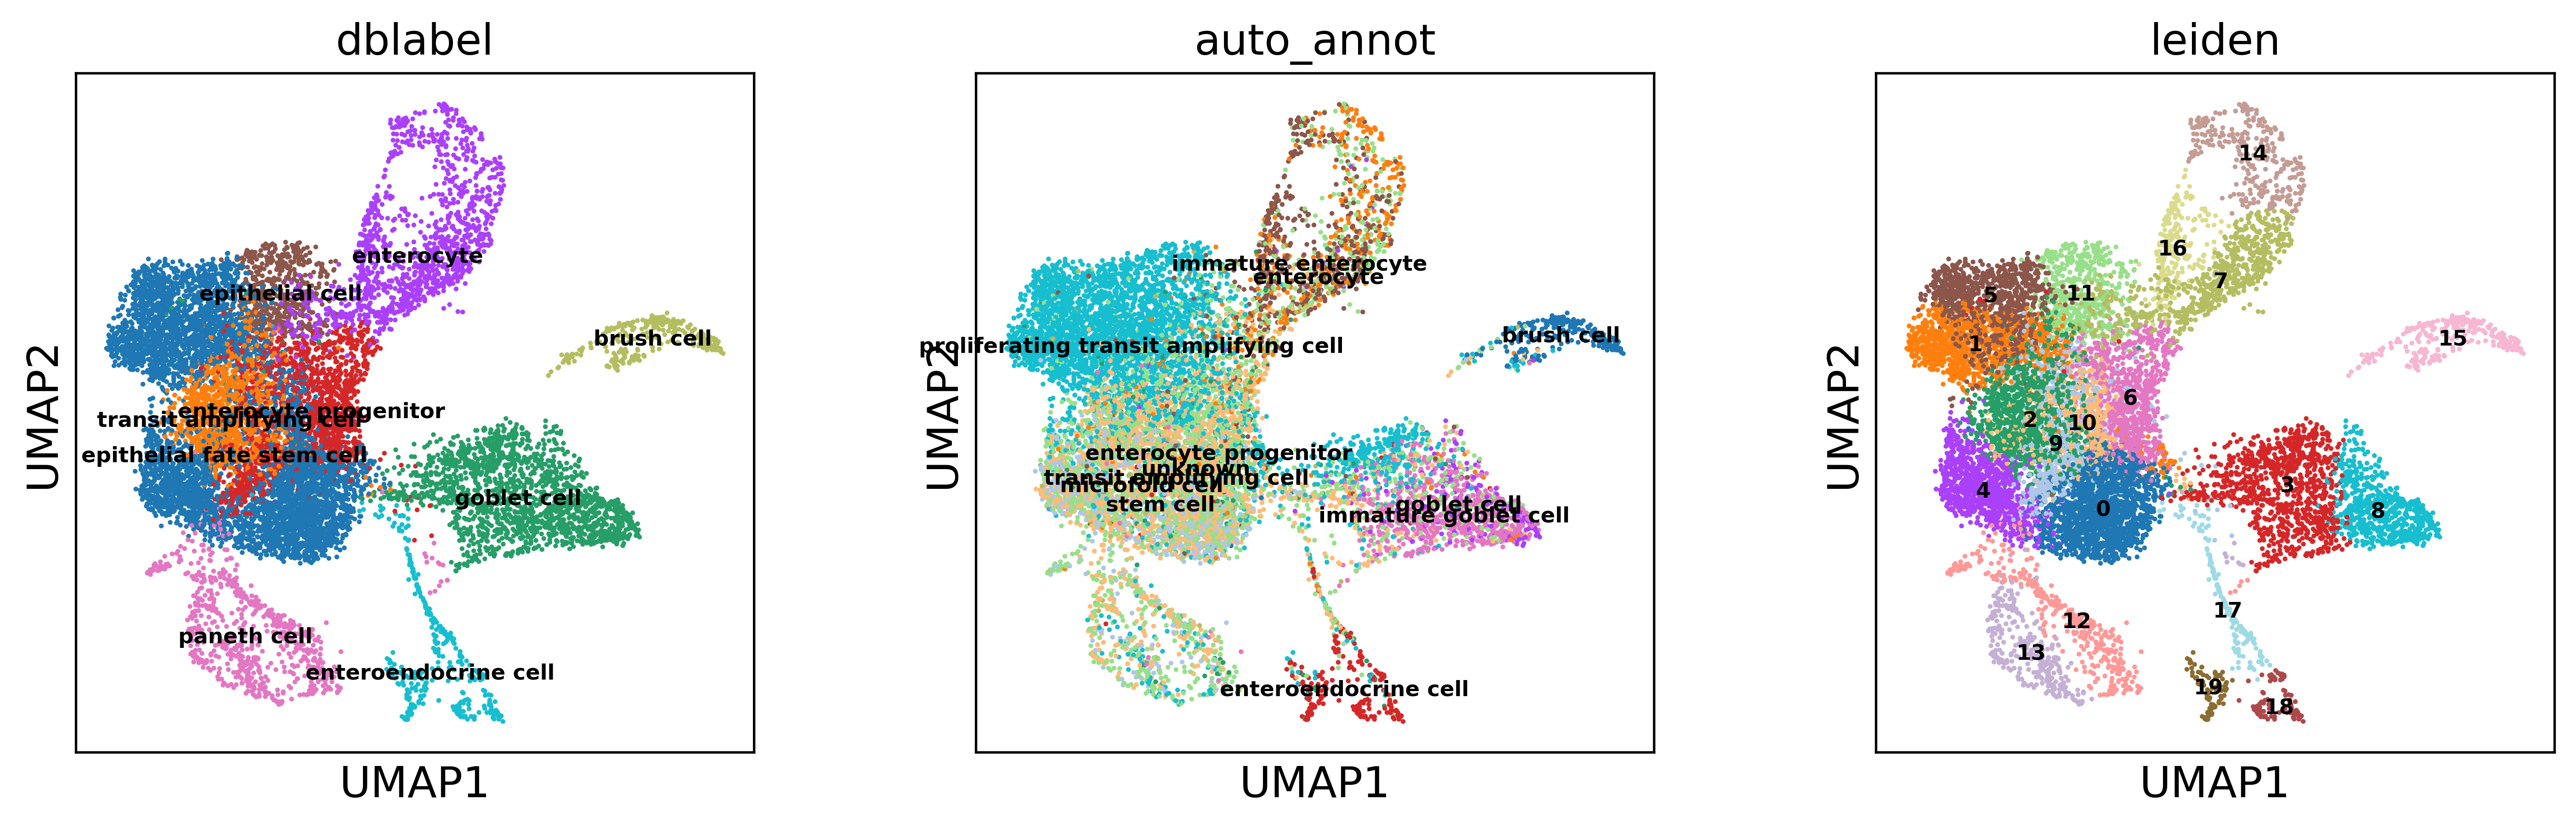

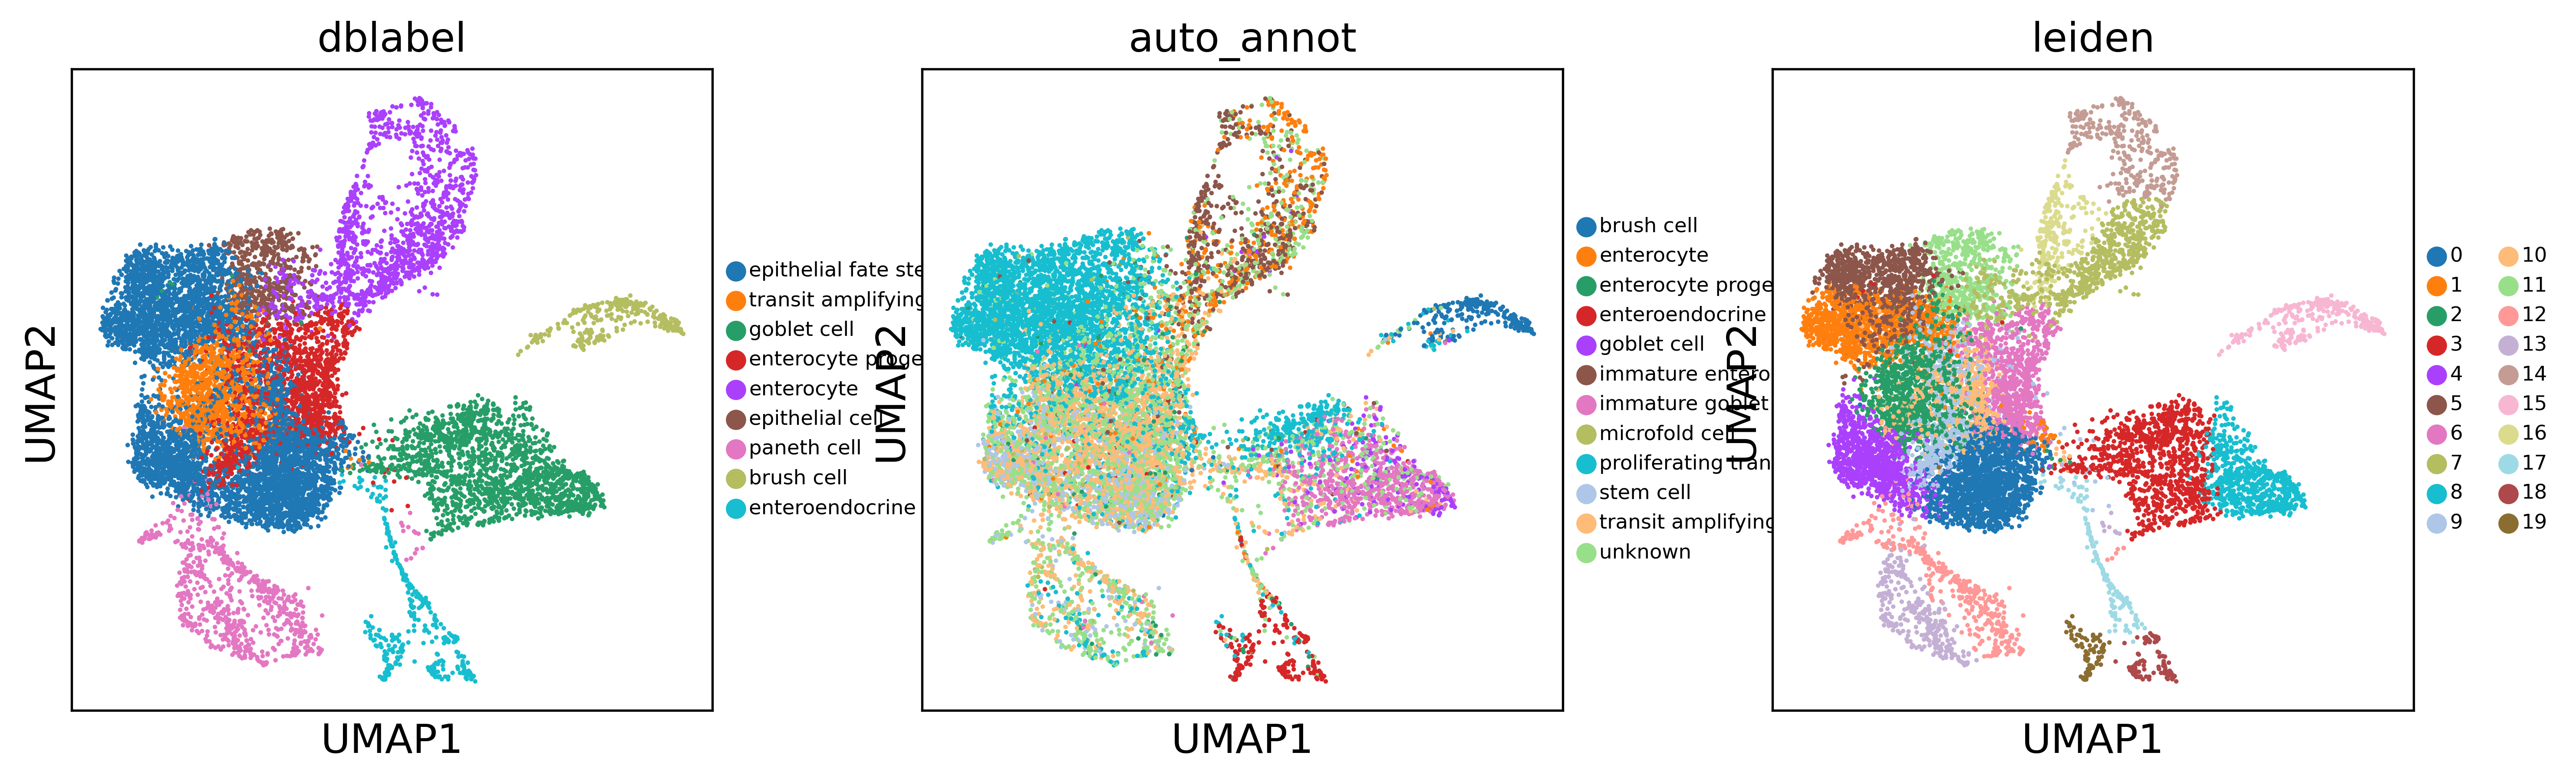

Confusion matrix, without normalization
Normalized confusion matrix


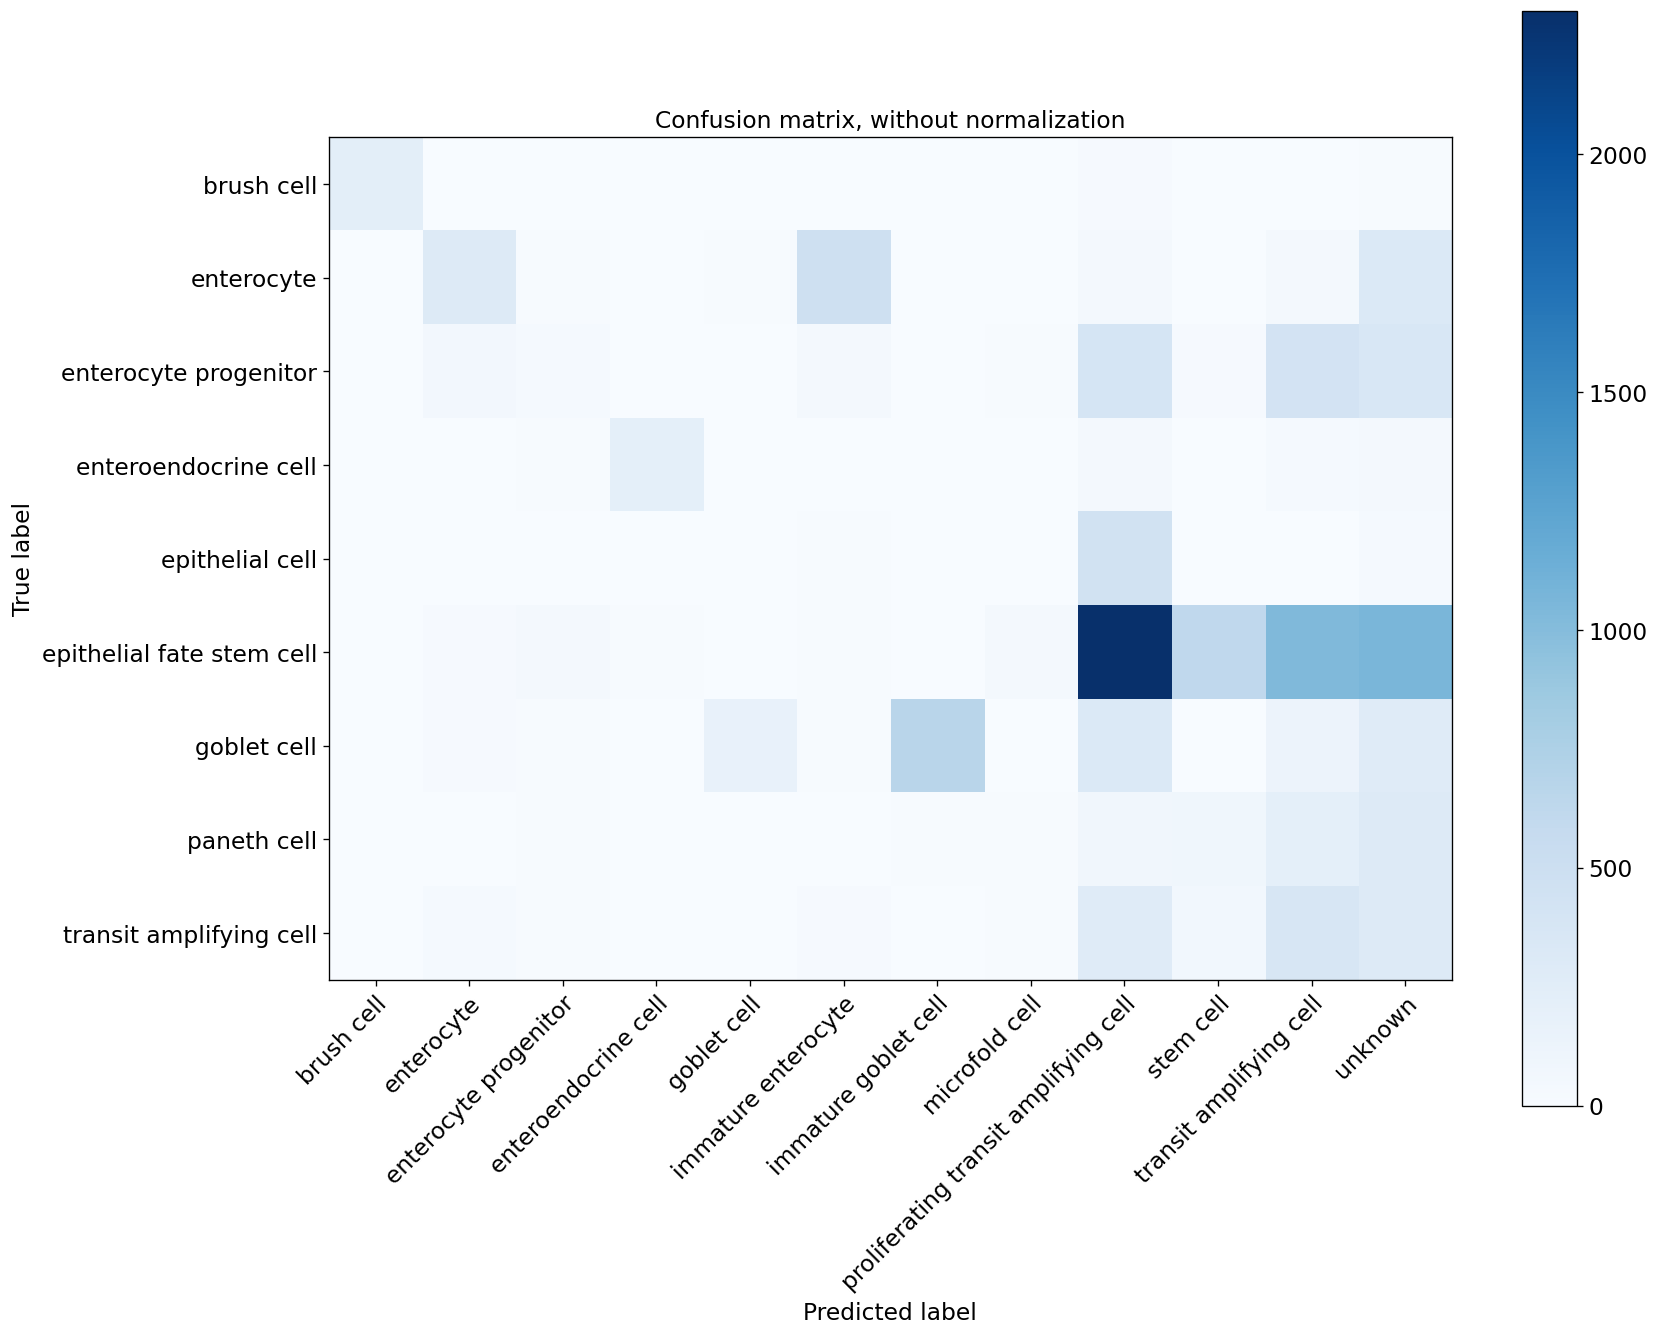

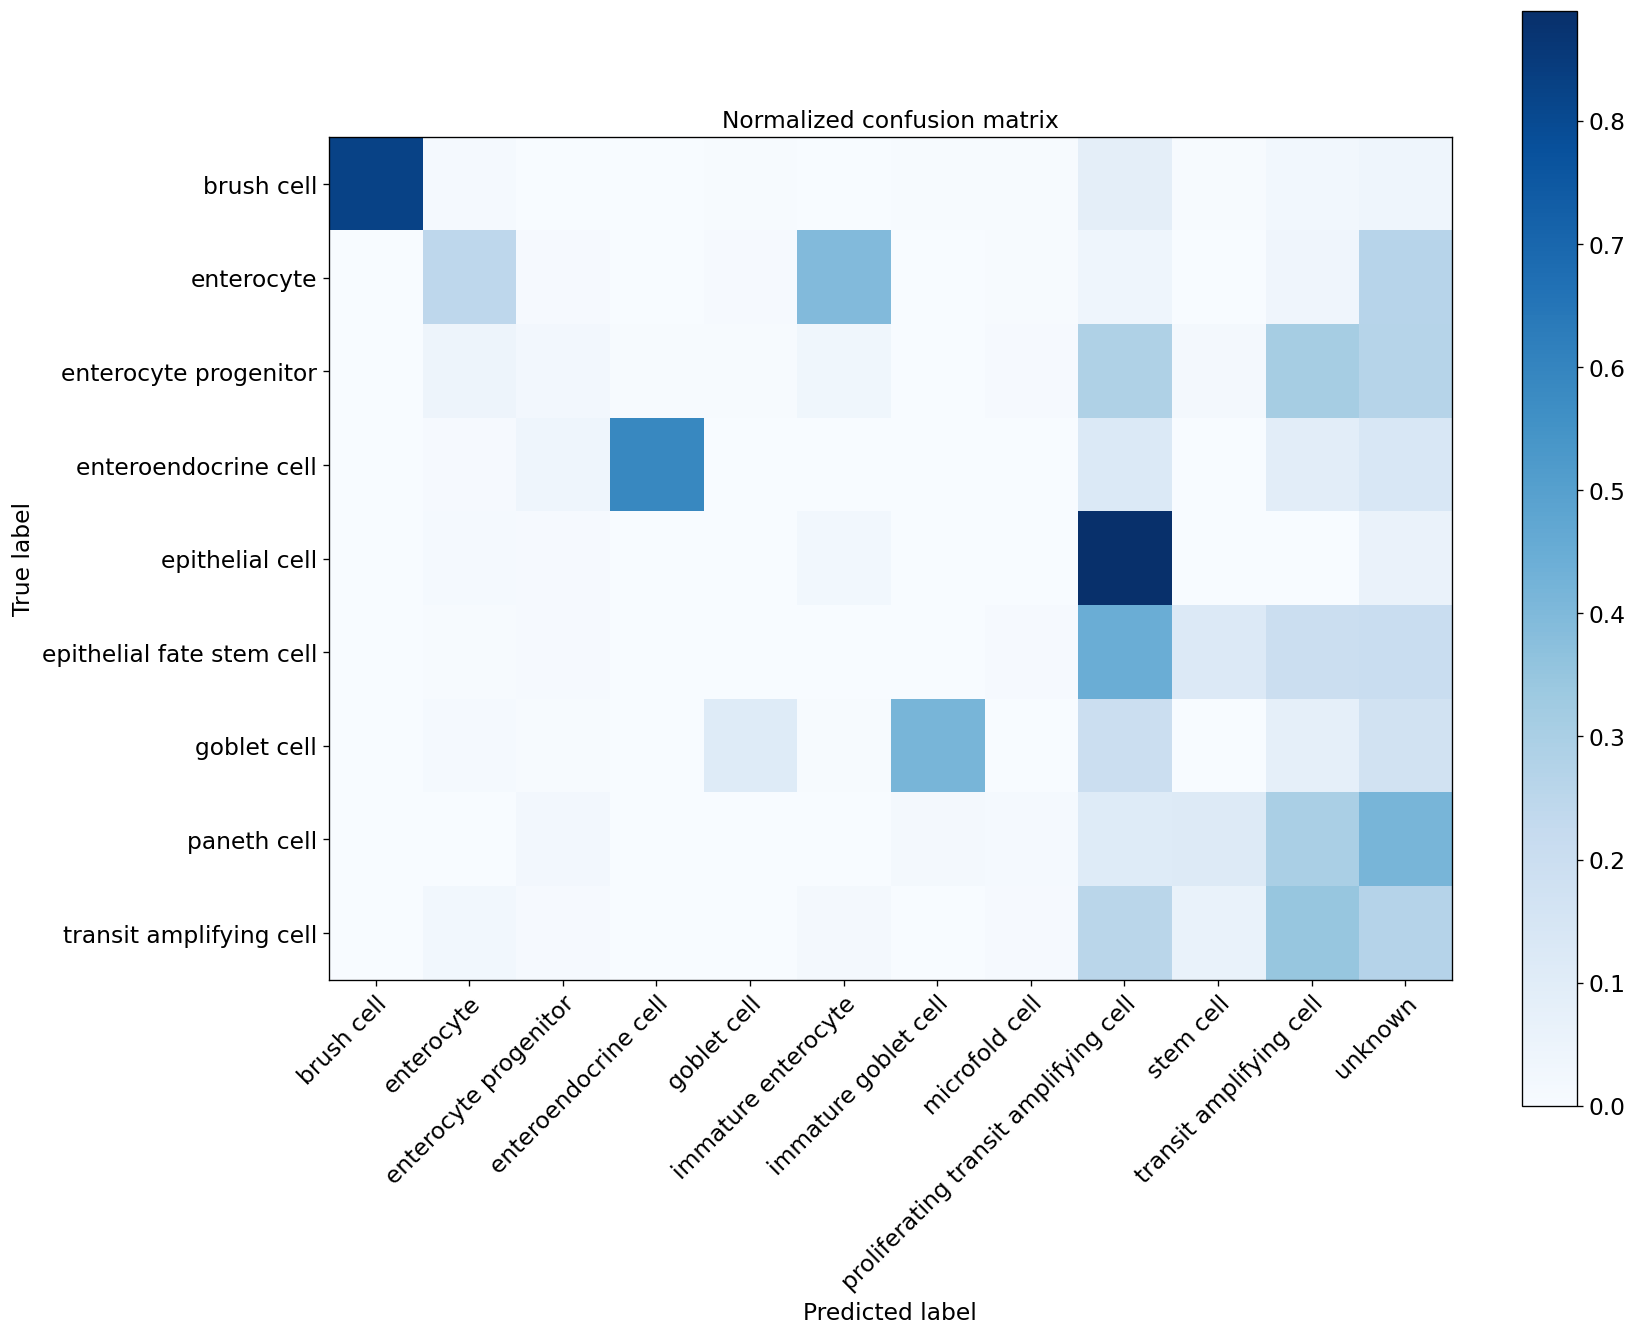

In [17]:
%matplotlib inline

bc.tl.auto_annot.report(adata_pred=adata_predicted, celltype=celltype_test, method=method, analysis_name=analysis_name,
                        train_datasets=adata_trains, test_dataset=adata_orig, merge=merge, use_raw=False,
                        genes_to_use=genes_to_use, remove_nonshared=True, clustering='leiden', asymmetric_matrix=True)

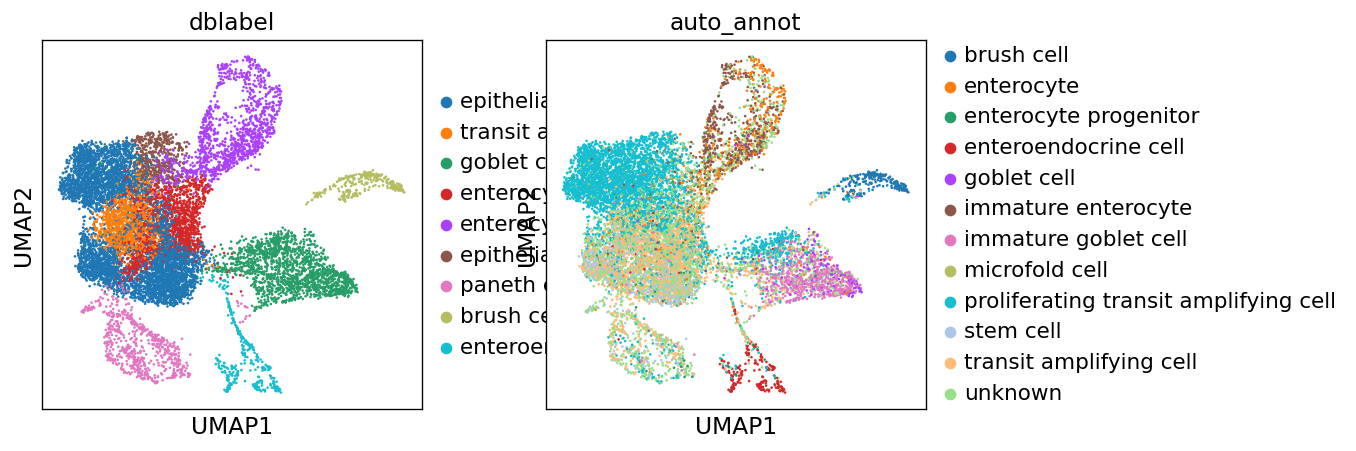

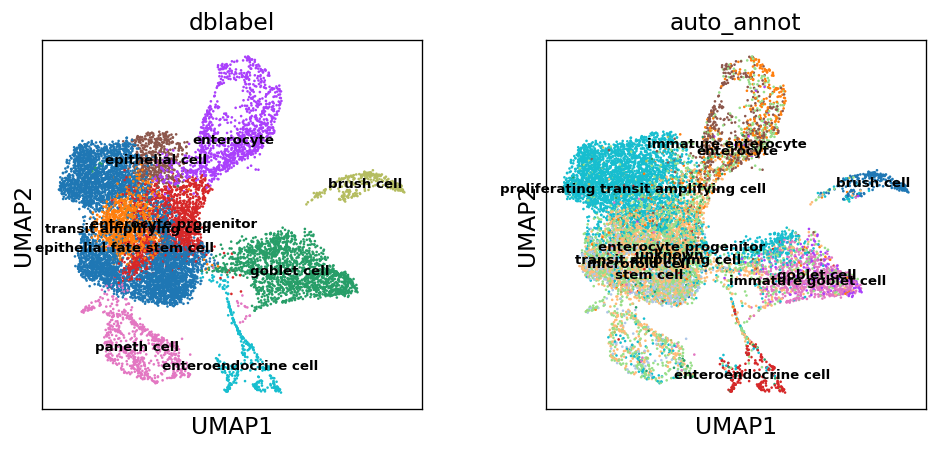

In [18]:
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'])
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'], legend_loc='on data', legend_fontsize=8)

In [19]:
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'], legend_fontsize=7, wspace = 1.4, save = '.svg')
sc.pl.umap(adata_predicted, color=[celltype_test, 'auto_annot'], legend_loc='on data', legend_fontsize=7, wspace = 1.4, save = '.ondata.svg')

In [20]:
adata_train

View of AnnData object with n_obs × n_vars = 46102 × 273
    obs: 'CELL', 'Cluster', 'Health', 'Location', 'Subject', 'celltype_highlevel', 'nGene', 'nUMI', 'original_name', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'leiden', 'dblabel', 'celltype', 'cluster_celltype', 'Type'
    var: 'SYMBOL', 'ENSEMBL-0', 'n_cells-0', 'total_counts-0', 'frac_reads-0', 'ENSEMBL-1', 'n_cells-1', 'total_counts-1', 'frac_reads-1', 'MGI-1'

In [21]:
from sinfo import sinfo
sinfo()

-----
anndata             0.7.4
besca               0+untagged.259.g3377592
pandas              1.0.5
pkg_resources       NA
scanpy              1.5.1
sinfo               0.3.1
sklearn             0.22.1
-----
IPython             7.11.1
jupyter_client      5.3.4
jupyter_core        4.6.1
notebook            6.0.3
-----
Python 3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 09:07:38) [GCC 7.3.0]
Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-centos-7.4.1708-Core
24 logical CPU cores, x86_64
-----
Session information updated at 2020-07-15 16:21
